## Matrix completion on graphs

### Introduction

We try and implement a matrix recovery model with a simulated Netflix-like dataset. The aim is to model a simple recommender system on netflix. Given a fixed percentage of observations on the matrix  users/movies, we want to recover all the values i.e the rating on each movie for each user. 

The original problem lies on the hypothesis -often verified in practixe- that a such users/movies matrix has a low rank.


Given a sparse set $\Omega$ of observations $M_ij : (i,j) \in \Omega \subseteq \{1,\cdots,n\}*\{1,\cdots,m\}$. We want to find:

$\displaystyle \min_{X \in \mathbb{R}^{m*n}} ||X||_{*}$ s.t $. \mathcal{A}_{\Omega}(X)=\mathcal{A}_{\Omega}(M)$

where $||X||_{*}$ is defined as the classical nuclear norm.


By taking advantage of common caracteristics about users and movies, we can improve the original problem of matrix completation. The [paper](https://arxiv.org/pdf/1408.1717.pdf) suggests the use of graph representation to handle this extra information. This notebook follows their experiments and shows the improvements over the original method to some extent.

### A syntetic example of Netflix problem

In [28]:
# -*- coding: utf-8 -*-
import pandas as pd
from itertools import *
import collections
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
import networkx as nx
%matplotlib inline

Let assume known information about users and movies, like age or sex, movies categories (War,Comedy, cartoons) or release date.


In [3]:
category = {'users' : {'sex' :['W','M'],
                     'age' :['<20','>50']},

            'movies' : {'genre':['Ca','Wa','Co'],
                      'release':['>2000','<1980']}
            }
            
tuplesU = list(product(*category['users'].values()))
tuplesM = list(product(*category['movies'].values()))

index = pd.MultiIndex.from_tuples(tuplesU, 
                                    names=category['users'].keys())
columns = pd.MultiIndex.from_tuples(tuplesM, 
                                  names=category['movies'].keys())

scores = [[3,2,4,3,1,3],[2,1,3,2,2,5],[2,5,2,4,1,2],[1,4,1,2,5,3]]
# buid table of scores by groups
scoresGroup = pd.DataFrame(index=index,columns=columns,data = scores)
print(scoresGroup)

genre      Ca          Wa          Co      
release >2000 <1980 >2000 <1980 >2000 <1980
age sex                                    
<20 W       3     2     4     3     1     3
    M       2     1     3     2     2     5
>50 W       2     5     2     4     1     2
    M       1     4     1     2     5     3


The table above gives rating for each category. For instance, a young boy is likely to like a recent war movie and dislike a comedy. This table of score is arbitrary and provides a toy example of a more real case.

Now we have to populate the users/movies matrix UM, according to the score matrix
- We define 10 to 12 individus in each group, namely the group of old men, old women, young boys and young girls 
- For movies, there is 6 groups made up 6 to 8 movies.

In [4]:
nbU = np.random.randint(10,12,len(tuplesU))
nbM = np.random.randint(6,8,len(tuplesM))

The code below build the UM matrix, and shuffle rows and columns

In [5]:
# buid columns and index with hierachical level
def build_individus(name,nbInd):
    tuplesInd = list(product(*category[name].values()))
    u = []
    it=0
    for g,n in zip(tuplesInd,nbInd):
        u+=[g+ (i,) for i in range(it,it+n)]
        it +=n
    index =  pd.MultiIndex.from_tuples(u, 
                                        names=list(category[name].keys())+[name])
    return index

# Mtrice Users/Movies creation  
def build_matriceUM(nbU,nbM):
    A = pd.DataFrame(index=    build_individus('users',nbU),
                 columns = build_individus('movies',nbM))
    # fill the matrix according to scoresGroup
    for blockM,blockU in product(tuplesM,tuplesU):
        A.loc[blockU,blockM] = scoresGroup.ix[blockU].ix[blockM]
    # shuffle lign and columns
    A = A.sample(frac=1,axis=0)
    A = A.sample(frac=1,axis=1)
    return A
    
UM = build_matriceUM(nbU,nbM)
print(UM.head())

genre            Wa          Ca    Wa    Ca    Wa          Co    Ca    Wa  \
release       <1980 >2000 >2000 >2000 >2000 >2000 <1980 >2000 >2000 >2000   
movies           20    13    1     15    5     18    21    31    0     19   
age sex users                                                               
<20 M   13        2     3     2     3     2     3     2     2     2     3   
>50 M   41        2     1     1     1     1     1     2     5     1     1   
        39        2     1     1     1     1     1     2     5     1     1   
        37        2     1     1     1     1     1     2     5     1     1   
    W   27        4     2     2     2     2     2     4     1     2     2   

genre          ...     Ca       Co       Ca             Co    Ca  
release        ...  >2000    <1980    <1980          >2000 <1980  
movies         ...     3  4     36 39    7  6  9  8     30    12  
age sex users  ...                                                
<20 M   13     ...      2  2     5  5 

C:\Users\KD5299\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


The matrix of weights, for movies and users have to be created, according to group caracteristics.

By instance, two young girls are linked in users matrix of weight by a 1. 

A recent war movie and old one do not belong to the same group and a 0 will be add in the movies matrix weight

In [36]:
# Create matrix of weigths
def build_weight(index,group):
    Weight = pd.DataFrame(index = index,columns=index,data=0)
    for row,col in zip(group,group):
        Weight.loc[row,col]= 1 #nbOfCommonFeature
    return Weight

WeightU = build_weight(UM.index,tuplesU)
WeightM = build_weight(UM.columns,tuplesM)
print(WeightM.head())


genre                   Wa          Ca    Wa    Ca    Wa          Co    Ca  \
release              <1980 >2000 >2000 >2000 >2000 >2000 <1980 >2000 >2000   
movies                  20    13    1     15    5     18    21    31    0    
genre release movies                                                         
Wa    <1980   20         1     0     0     0     0     0     1     0     0   
      >2000   13         0     1     0     1     0     1     0     0     0   
Ca    >2000   1          0     0     1     0     1     0     0     0     1   
Wa    >2000   15         0     1     0     1     0     1     0     0     0   
Ca    >2000   5          0     0     1     0     1     0     0     0     1   

genre                   Wa  ...     Ca       Co       Ca             Co    Ca  
release              >2000  ...  >2000    <1980    <1980          >2000 <1980  
movies                  19  ...     3  4     36 39    7  6  9  8     30    12  
genre release movies        ...                          

We can visualize graph of individus for instance with:

In [49]:
def plot_graph(Weight,level='users'):
    G=nx.Graph()
    # for all combinations between users, update weight graphs
    for tupleEdge in combinations(Weight.index.get_level_values(level),2):
        weight = Weight.xs(tupleEdge[0], level='users', axis=0).xs(tupleEdge[1], level=level, axis=1).values
        G.add_edge(*tupleEdge,weight=weight)
    # 
    elarge=[(a,b) for (a,b,d) in G.edges(data=True) if d['weight'] ==1]
    pos=nx.spring_layout(G) # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=700)
    # edges
    nx.draw_networkx_edges(G,pos,edgelist=elarge,
                        width=1)
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    plt.axis('off')
    plt.show() # display

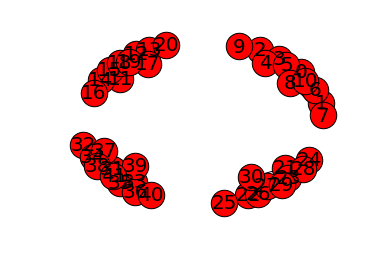

In [50]:
plot_graph(WeightU,'users')

Let assume that we have partial measurements of $UM$. Some users have scored some movies, but UM entries has a lot of empty spaces. Let us observe **5%** for the next examples of the $UM$ matrix. The goal is now to rebuild it.

In [37]:
def mask(u, v, proportion = 0.3):
    mat_mask = np.random.binomial(1, proportion, size =  (u, v))
    print("We observe {} per cent of the entries of a {}*{} matrix".format(100 * mat_mask.mean(),u, v))
    return mat_mask

mat_mask = mask(*UM.shape,proportion=0.05)
UM_mask = mat_mask*UM

We observe 5.11904761905 per cent of the entries of a 42*40 matrix


### Let us recall the original problem

The matrix of weights are not used here, so we want to find : 
$\displaystyle \min_{X \in \mathbb{R}^{m*n}} ||X||_{*}$ s.t $. \mathcal{A}_{\Omega}(X)=\mathcal{A}_{\Omega}(M)$

The library CVXPY provide user-friendly tools to define this problem

In [8]:
X = Variable(*UM.shape)
obj = Minimize(norm(X, 'nuc') )  # norm nuclear: hypotesis of low rank
constraints = [mul_elemwise(mat_mask, X) == mul_elemwise(mat_mask, np.array(UM))]
prob = Problem(obj, constraints)
prob.solve(solver=SCS)
UM_rebuild = pd.DataFrame(index = UM.index,columns=UM.columns,data=X.value)

In [9]:
def rmse(A,B):
    rmse = ((A-B).values**2).mean()
    print("RMSE: %.2f" %rmse)
    return rmse

The RMSE of the recovered solution can be find:

In [10]:
rmse(UM,UM_rebuild)

RMSE: 6.68


6.680457170479519

### With the information of similar rating over groups:

Now, by putting aside low rank hypothesis, the intuition is to force two different vectors of users noted $x_{i}$ and $x_{i'}$ to be closed when their respective link $w_{ii'}^{u}$ are not zero. $w_{ii'}^{u}$ is the entries of the matrix of weight for users $W^{c}$.  Namely, we want to find $X \in \mathbb{R}^{m*n}$ minimizing ;

$\sum\limits_{i,i'} w_{ii'}^{u}||x_{i}-x_{i'}||_{2}^{2} = tr(XL_{u}X^t) =  ||X||^2_{\mathcal{D},u} $

We then define  positive semidefinite matrix $L^{u}$ defined as $D^{u}-W^{u}$ where is defined such that :$(D^{u})_{ij}=diag(\sum_{j=1}^m W_{ij}^{u})$.

The same idea is applied for movies vectors.


So, the problem of matrix completion can be formulated as follows :


$\displaystyle \min_{X} \frac{\gamma_u}{2}||X||^2_{\mathcal{D},u}+\frac{\gamma_m}{2}||X||^2_{\mathcal{D},m}$ 

In [11]:
def build_L(Weight):
    D =  np.diag(Weight.sum(axis=0))
    L = (D-Weight).values
    return L
LM = build_L(WeightM)
LU = build_L(WeightU)

Since it is not that easy to find a procedure minimizing $||X||^2_{\mathcal{D},u}$, we have expressed $X$ in other basis, in order to take benefit from the cvxpy toolbox. Indeed, we can use $tr(XX^t) = ||X||^2_{\mathcal{F}}$, which is the square of the Frobenius norm.

More precisions may be found in our report, stored in this Github repository.

In [12]:
def change_basis(L):
    V,P = np.linalg.eigh(L) # diagonalise
    V1 = np.diag(np.sqrt(np.abs(V))) 
    P1 = np.dot(P,V1)
    return P1

In [13]:
PM1 = change_basis(LM)
PU1 = change_basis(LU)

In [14]:
X = Variable(*UM.shape)
obj = Minimize(norm(X*PM1, 'fro') + norm((PU1.T)*X, 'fro')) # norm frobenius: information from graphs
constraints = [mul_elemwise(mat_mask, X) == mul_elemwise(mat_mask, np.array(UM))]
prob = Problem(obj, constraints)
prob.solve(solver=SCS)


6.78323494167496e-05

In [15]:
UM_rebuild = pd.DataFrame(index = UM.index,columns=UM.columns,data=X.value)
rmse(UM,UM_rebuild)

RMSE: 1.04


1.0416666834620083

The rmse is here better than the first case. 

### Comparision of those methods, under several scenarios

To assess the improvement from graphs information, a lot of cases have been simulated. We wanted to compare the performances in term of RMSE for the matrix completion problem with:
- Nuclear norm, based on low rank hypothesis
- Graph information 
- The combination of both

Under several scenarios:
- With noise in the matrix of weight. Some 1 have been added, creating a wrong link, or some 0 have replaced 1, removing a correct link.
- With different percentages of $UM$'s observation.


To add noise, we can use a XOR provided by numpy to flip the bits of the matrix of weight. We delete some links inside the communities or create ones between them:

We observe 10.0340136054 per cent of the entries of a 42*42 matrix


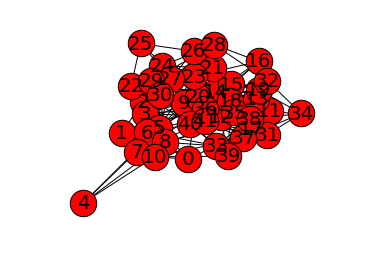

In [53]:
WeightU_noise =  np.logical_xor(WeightU,mask(*WeightU.shape,proportion=0.1))
plot_graph(WeightU_noise,'users')


In [38]:
# optimization problem inside a function
def rebuild(nuc,fro,PM1,PU1,mat_mask):
    X = Variable(*UM.shape)
    obj = Minimize(nuc*norm(X, 'nuc') +  # norm nuclear: hypotesis of low rank
                   fro*(norm(X*PM1, 'fro') + norm((PU1.T)*X, 'fro'))) # norm frobenius: information from graphs
    constraints = [mul_elemwise(mat_mask, X) == mul_elemwise(mat_mask, np.array(UM))]
    prob = Problem(obj, constraints)
    prob.solve(solver=SCS)
    UM_rebuild = pd.DataFrame(index = UM.index,columns=UM.columns,data=X.value)
    return UM_rebuild

The dataframe containing results is now created

In [39]:
dic_result={'noise':range(0,40,10),
            'nuc':[0,1],
            'fro':[0,1]}

result = pd.DataFrame(index=pd.MultiIndex.from_product(dic_result.values(),
                                                       names=dic_result.keys()),
        columns=range(0,80,10))
result = result.ix[~((result.index.get_level_values('nuc')==0) & (result.index.get_level_values('fro')==0))]
print(result.head())


                0    10   20   30   40   50   60   70
noise fro nuc                                        
0     0   1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
      1   0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
          1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
10    0   1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
      1   0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


The loops to fill it:

In [40]:
for observation in result.columns:
    proportion = observation/100.
    mat_mask = mask(*UM.shape,proportion=proportion)
    for noise,fro,nuc in product(*result.index.levels):
        if ~((nuc==0) & (fro==0)):
#            print(noise,fro,nuc)
            WeightM_noise = np.logical_xor(WeightM,mask(*WeightM.shape,proportion=noise/100.))
            WeightU_noise =  np.logical_xor(WeightU,mask(*WeightU.shape,proportion=noise/100.))
            LU_noise = build_L(WeightU_noise)
            LM_noise = build_L(WeightM_noise)
            UM_rebuild =  rebuild(nuc,fro,
                                  change_basis(LM_noise),
                                  change_basis(LU_noise),mat_mask)
            r = rmse(UM_rebuild,UM)
            result.loc[(noise,fro,nuc),observation] = r

We observe 0.0 per cent of the entries of a 42*40 matrix
We observe 0.0 per cent of the entries of a 40*40 matrix
We observe 0.0 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 0.0 per cent of the entries of a 40*40 matrix
We observe 0.0 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 0.0 per cent of the entries of a 40*40 matrix
We observe 0.0 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 10.5625 per cent of the entries of a 40*40 matrix
We observe 9.92063492063 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 9.625 per cent of the entries of a 40*40 matrix
We observe 9.58049886621 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 9.3125 per cent of the entries of a 40*40 matrix
We observe 10.0907029478 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 19.5 per cent of the entries of a 40*40 matrix
We observe 20.5782312925 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 19.125 

It yields to the next graphs, showing the effect of noise, for different percentages of observation:

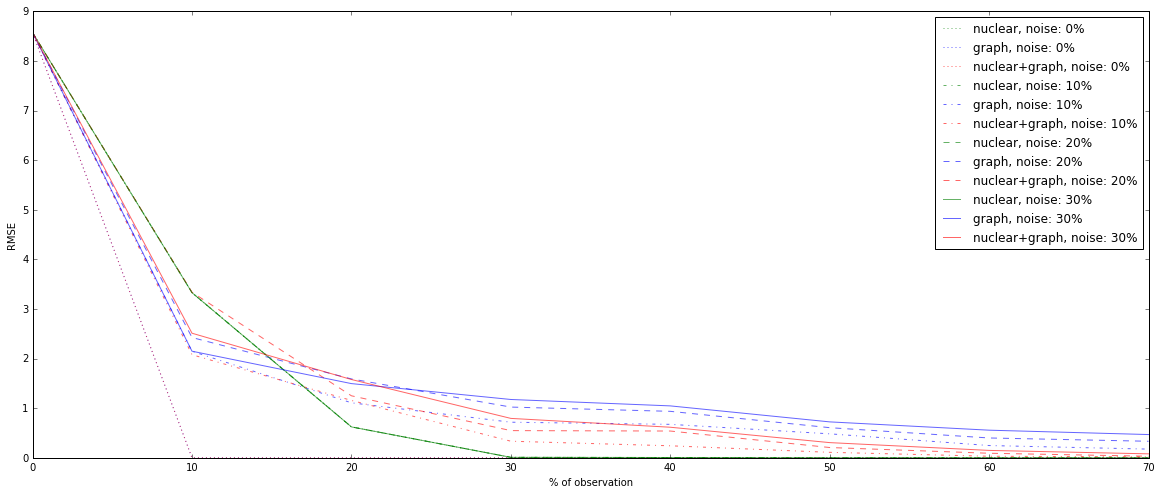

In [41]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
color_dic = {(0,1):'b',(1,1):'r',(1,0):'g'}
style_dic = {k:v for k,v in zip(dic_result['noise'],[':','-.','--','-'])}
result.loc[(slice(None),1,1),:]
for noise,fro,nuc in  product(*result.index.levels):
    if ~((nuc==0) & (fro==0)):    
        label = nuc*'nuclear'+ nuc*fro*'+'+ fro*'graph' +', noise: '+ str(noise)+ '%'
        result.loc[(noise,fro,nuc),:].T.plot(color = color_dic[(nuc,fro)],
                                            style=style_dic[noise],
                                            label=label,
                                            alpha = 0.6)
ax.legend()
ax.set_xlabel('% of observation')
ax.set_ylabel('RMSE')


As we can show, information of communities is very strong, and outperforms the original problem if there is no noise. In case of noise for the matrix of weights, 30% of wrong links for instance, the first problem based on nuclear norm minimization gets better result from more than 10% of observations.


To be more realistic, the matrix of weight have been made sparser. The half of links is removed:

In [42]:
WeightU = WeightU*mask(*WeightU.shape,proportion = 0.5)
WeightM = WeightM*mask(*WeightM.shape,proportion = 0.5)

We observe 52.2675736961 per cent of the entries of a 42*42 matrix
We observe 49.125 per cent of the entries of a 40*40 matrix


The same fillling is done:

In [43]:
for observation in result.columns:
    proportion = observation/100.
    mat_mask = mask(*UM.shape,proportion=proportion)
    for noise,fro,nuc in product(*result.index.levels):
        if ~((nuc==0) & (fro==0)):
#            print(noise,fro,nuc)
            WeightM_noise = np.logical_xor(WeightM,mask(*WeightM.shape,proportion=noise/100.))
            WeightU_noise =  np.logical_xor(WeightU,mask(*WeightU.shape,proportion=noise/100.))
            LU_noise = build_L(WeightU_noise)
            LM_noise = build_L(WeightM_noise)
            UM_rebuild =  rebuild(nuc,fro,
                                  change_basis(LM_noise),
                                  change_basis(LU_noise),mat_mask)
            r = rmse(UM_rebuild,UM)
            result.loc[(noise,fro,nuc),observation] = r

We observe 0.0 per cent of the entries of a 42*40 matrix
We observe 0.0 per cent of the entries of a 40*40 matrix
We observe 0.0 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 0.0 per cent of the entries of a 40*40 matrix
We observe 0.0 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 0.0 per cent of the entries of a 40*40 matrix
We observe 0.0 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 9.4375 per cent of the entries of a 40*40 matrix
We observe 10.2607709751 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 9.75 per cent of the entries of a 40*40 matrix
We observe 9.80725623583 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 10.125 per cent of the entries of a 40*40 matrix
We observe 10.0340136054 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 19.875 per cent of the entries of a 40*40 matrix
We observe 18.820861678 per cent of the entries of a 42*42 matrix
RMSE: 8.57
We observe 20.125 p

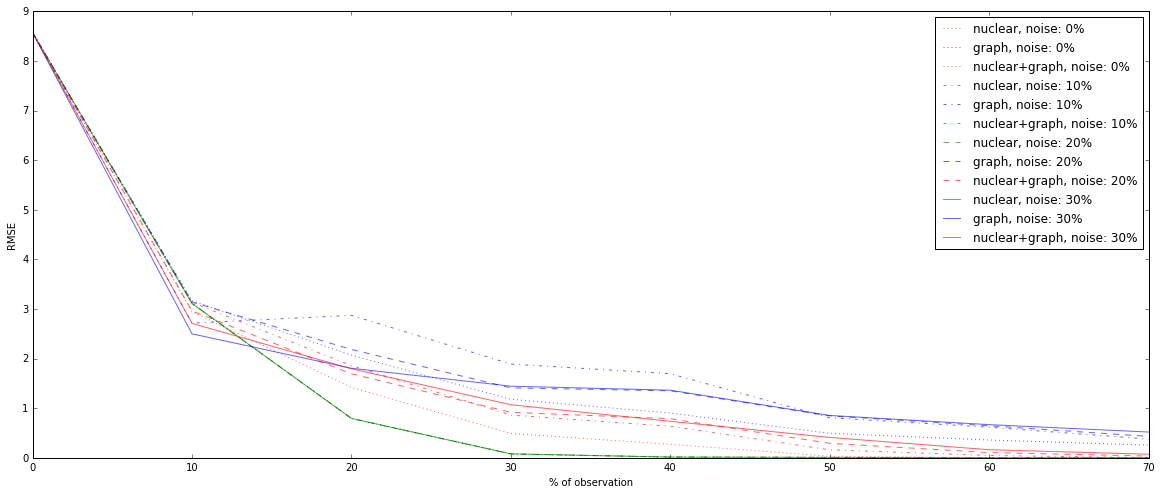

In [44]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
color_dic = {(0,1):'b',(1,1):'r',(1,0):'g'}
style_dic = {k:v for k,v in zip(dic_result['noise'],[':','-.','--','-'])}
result.loc[(slice(None),1,1),:]
for noise,fro,nuc in  product(*result.index.levels):
    if ~((nuc==0) & (fro==0)):    
        label = nuc*'nuclear'+ nuc*fro*'+'+ fro*'graph' +', noise: '+ str(noise)+ '%'
        result.loc[(noise,fro,nuc),:].T.plot(color = color_dic[(nuc,fro)],
                                            style=style_dic[noise],
                                            label=label,
                                            alpha = 0.6)
ax.legend()
ax.set_xlabel('% of observation')
ax.set_ylabel('RMSE')

With partial information of communities membership, the results are worse. Basically, for 10% of observation, graph-based resolution is still better, but after, nuclear norm based optimization becomes more accurate.
